In [ ]:
!pip install huggingface-hub
!huggingface-cli login 
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `Colab` has been saved to /home/weef/.cache/huggingface/stored_tokens
Your token has been saved to /home/weef/.cache/huggingface/token
Login successful.
The current active token is: `Colab`
Defaulting to user installation because normal site-packages is not writeable


### Sistema de recomendação para predição de carreira

O sistema de recomendação utilizado nesse contexto tem como objetivo prever o próximo passo de carreira de um indivíduo 
com base no histórico de experiências anteriores, utilizando uma abordagem de ranqueamento. 

### Aqui estão os principais aspectos do sistema:

#### Problema de Ranqueamento 

O sistema considera todas as ocupações da ontologia ESCO como possíveis opções para o próximo passo de carreira.

Ele ranqueia essas ocupações com base em quão adequadas elas são, dado o histórico de carreira do indivíduo.

**O objetivo é que a ocupação real escolhida pelo indivíduo (chamada de "rótulo verdadeiro") esteja no topo do ranqueamento.**

#### Modelagem do Problema

- O histórico de carreira é representado como uma sequência de experiência anteriores, 
(𝑒𝑥1,...,𝑒𝑥𝑖−1) (ex1,...,exi−1).
- A função de pontuação  𝑆 avalia a compatibilidade entre o histórico e cada ocupação ESCO. 
- Ela gera uma pontuação para cada ocupação, indicando sua adequação como o próximo passo.
- As ocupações são ranqueadas da maior para a menor pontuação, e as mais bem ranqueadas são apresentadas como recomendações.

#### Métricas de Avaliação

- Para medir a qualidade das recomendações, são usadas métricas baseadas em ranqueamento:

   - **Mean Reciprocal Rank (MRR):** Mede a posição do rótulo verdadeiro no ranqueamento.

   - **Recall@5 (R@5):** Avalia se o rótulo verdadeiro aparece entre as 5 primeiras recomendações.

   - **Recall@10 (R@10):** Avalia se o rótulo verdadeiro aparece entre as 10 primeiras recomendações.

#### Métodos Utilizados
O sistema utiliza três abordagens principais para resolver o problema de ranqueamento:

- **Abordagem Baseada na Ontologia ESCO:**
   - Explora informações semânticas da ontologia ESCO, como relações entre ocupações, habilidades requeridas e áreas de conhecimento.
   - Essa abordagem aproveita a estrutura hierárquica e os vínculos entre as ocupações para melhorar a relevância das recomendações.

- **Representação e Regressão:**
   - Usa aprendizado de representação para transformar o histórico de experiências e as ocupações em vetores numéricos.
   - Um modelo de regressão é treinado para prever a compatibilidade entre o histórico e cada ocupação com base nessas representações.

- **Método Híbrido:**
   - Combina as duas abordagens anteriores, integrando a riqueza semântica da ontologia ESCO com os benefícios do aprendizado de representação.
   - Esse método busca aproveitar o melhor dos dois mundos para melhorar a qualidade das recomendações.

### Resumo

Este sistema de recomendação é híbrido e personalizado, utilizando tanto informações estruturais da ontologia quanto técnicas de aprendizado de máquina. Ele não apenas ranqueia as ocupações com base na adequação ao histórico do usuário, mas também oferece flexibilidade para apresentar múltiplas recomendações úteis (top-5 ou top-10), o que é especialmente importante em aplicações práticas de recomendação de carreiras.

### Carregando dados

In [4]:
import pandas as pd

splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
train = pd.read_csv("hf://datasets/jensjorisdecorte/anonymous-working-histories/" + splits["train"])
test = pd.read_csv("hf://datasets/jensjorisdecorte/anonymous-working-histories/" + splits["test"])
validation = pd.read_csv("hf://datasets/jensjorisdecorte/anonymous-working-histories/" + splits["validation"])



merged_dataset = pd.concat([train, test, validation], axis=0, ignore_index=True)

/home/weef/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
experience_counts = merged_dataset['number_of_experiences'].value_counts().sort_index()

# Calcular a proporção e a proporção acumulada
experience_distribution = pd.DataFrame({
    'count': experience_counts,
    'percentage': experience_counts / experience_counts.sum(),
    'cumulative_percentage': (experience_counts / experience_counts.sum()).cumsum()
})

# Determinar o número máximo de experiências para representar 70% dos dados
threshold = 0.7
max_experiences_for_70_percent = experience_distribution[
    experience_distribution['cumulative_percentage'] <= threshold
].index.max()

# Exibir os resultados
print("\nDistribuição por número de experiências:")
print(experience_distribution)



Distribuição por número de experiências:
                       count  percentage  cumulative_percentage
number_of_experiences                                          
2                         96    0.044362               0.044362
3                        579    0.267560               0.311922
4                        704    0.325323               0.637246
5                        263    0.121534               0.758780
6                        195    0.090111               0.848891
7                        145    0.067006               0.915896
8                         81    0.037431               0.953327
9                         47    0.021719               0.975046
10                        29    0.013401               0.988447
11                         9    0.004159               0.992606
12                         5    0.002311               0.994917
13                         5    0.002311               0.997227
14                         3    0.001386               0.99861

In [6]:
industry = merged_dataset['industry'].value_counts().sort_index()
industry

industry
ACCOUNTANT                106
ADVOCATE                  104
AGRICULTURE                62
APPAREL                    87
ARTS                       93
AUTOMOBILE                 29
AVIATION                   92
BANKING                    98
BPO                        19
BUSINESS-DEVELOPMENT      106
CHEF                      103
CONSTRUCTION               88
CONSULTANT                103
DESIGNER                   90
DIGITAL-MEDIA              82
ENGINEERING                97
FINANCE                   108
FITNESS                   102
HEALTHCARE                 98
HR                         98
INFORMATION-TECHNOLOGY    102
PUBLIC-RELATIONS           99
SALES                     107
TEACHER                    91
Name: count, dtype: int64

In [7]:
train.head(3)

,identifier,industry,number_of_experiences,uuid_0,title_0,description_0,start_0,end_0,ESCO_uri_0,ESCO_title_0,...,end_15,ESCO_uri_15,ESCO_title_15,uuid_16,title_16,description_16,start_16,end_16,ESCO_uri_16,ESCO_title_16
0,12717345,CHEF,4,8b05d17d-36de-806f-fc03-9968c90e41c5,Line Cook,- Prepped food for the line and cooked appetiz...,10/2004,04/2005,http://data.europa.eu/esco/occupation/90f75f67...,cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86551046,CHEF,5,f1fc83d8-5d17-d560-93ca-c6873aa402d8,Banquet Cook 2( Lead Cook),- Attended daily BEO meetings\n- Prepped and f...,02/2014,12/2014,http://data.europa.eu/esco/occupation/90f75f67...,cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29772450,CHEF,6,ccfefc21-0391-a0f6-2e56-0149099d633a,Executive Sous Chef / Production Manager,Perform all essential duties as lead chef in t...,01/1988,01/1993,http://data.europa.eu/esco/occupation/a7d6a377...,food production manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recomendação Baseada em Habilidades (Skill-based Prediction)

A abordagem de recomendação baseada em habilidades explora a relação entre as habilidades de uma pessoa e as ocupações em seu caminho de carreira. A ideia central é que as habilidades de um indivíduo desempenham um papel importante nas decisões sobre quais cargos ele pode ocupar a seguir.

### Como funciona:

- **Habilidades das Ocupações:**

    - Na ontologia ESCO, cada ocupação é associada a um conjunto de habilidades, que são divididas em habilidades "essenciais" e "opcionais". O conjunto de habilidades 𝒮(occ) para uma ocupação inclui tanto as habilidades essenciais quanto as opcionais.


- **Representação das Habilidades do Histórico de Carreira:**

    - O histórico de carreira é representado como uma sequência de ocupações occ1, occ2, ..., occ𝑁.
    - As habilidades associadas a cada ocupação são extraídas de 𝒮(occ𝑖), e a união de todas as habilidades relacionadas a essas ocupações forma o conjunto total de habilidades adquiridas ao longo da carreira: 
    - 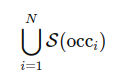
    - Esse conjunto de habilidades representa as competências do trabalhador ao longo de sua trajetória.
  
- **Medição da Compatibilidade das Habilidades:**

    - Para cada nova ocupação occ, a recomendação é feita com base na compatibilidade de habilidades entre as habilidades do histórico de carreira e as habilidades exigidas pela ocupação occ.
    - O índice de correspondência de habilidades (𝑆SKILLS) é calculado como a fração de habilidades que a ocupação occ exige e que estão presentes no histórico de carreira do indivíduo. A fórmula é:
    - 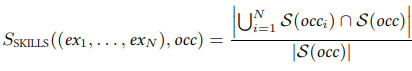
    - O índice de correspondência é, portanto, uma medida da sobreposição de habilidades entre o histórico de carreira e as habilidades exigidas para a ocupação.
- **Ranqueamento das Ocupações:**

   - O sistema utiliza 𝑆SKILLS para ranquear todas as ocupações occ possíveis, do maior para o menor índice de correspondência.
   - As ocupações com maior 𝑆SKILLS são mais recomendadas, pois têm mais habilidades em comum com o histórico de carreira do indivíduo.
### Resumo:
A recomendação baseada em habilidades foca na sobreposição de habilidades entre o histórico de carreira e as ocupações futuras possíveis. A partir da ontologia ESCO, são identificadas as habilidades essenciais e opcionais para cada ocupação. O sistema calcula uma "pontuação de correspondência" entre as habilidades do trabalhador e as habilidades exigidas por cada ocupação, ranqueando as ocupações com base nessa pontuação para prever a próxima posição na carreira.

#### Preparando Dataset de Skills

##### Ocupações

- conceptUri: Representa a URI da ocupação

In [8]:
occupations = pd.read_csv('./data/occupations_en.csv')
occupations.head(1)

,conceptType,conceptUri,iscoGroup,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,regulatedProfessionNote,scopeNote,definition,inScheme,description,code
0,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2654,technical director,technical and operations director\nhead of tec...,NaN,released,2024-01-25T11:28:50.295Z,http://data.europa.eu/esco/regulated-professio...,NaN,NaN,http://data.europa.eu/esco/concept-scheme/occu...,Technical directors realise the artistic visio...,2654.1.7


#### Lista de Skills

In [9]:
skills = pd.read_csv('./data/skills_en.csv')
skills.head(1)

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,sector-specific,manage musical staff,manage staff of music\ncoordinate duties of mu...,NaN,released,2023-11-30T15:53:37.136Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Assign and manage staff tasks in areas such as...


#### Relação Skills x Ocupação

In [10]:
relations = pd.read_csv('./data/occupationSkillRelations_en.csv')
relations.head(1)

,occupationUri,relationType,skillType,skillUri
0,http://data.europa.eu/esco/occupation/00030d09...,essential,knowledge,http://data.europa.eu/esco/skill/fed5b267-73fa...


In [11]:
relations_with_occupations = relations.merge(
    occupations,
    left_on="occupationUri",
    right_on="conceptUri",
    how="left"
)
esco_data = relations_with_occupations.merge(
    skills,
    left_on="skillUri",
    right_on="conceptUri",
    how="left"
)

esco_data.head(2)

,occupationUri,relationType,skillType_x,skillUri,conceptType_x,conceptUri_x,iscoGroup,preferredLabel_x,altLabels_x,hiddenLabels_x,...,reuseLevel,preferredLabel_y,altLabels_y,hiddenLabels_y,status_y,modifiedDate_y,scopeNote_y,definition_y,inScheme_y,description_y
0,http://data.europa.eu/esco/occupation/00030d09...,essential,knowledge,http://data.europa.eu/esco/skill/fed5b267-73fa...,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2654,technical director,technical and operations director\nhead of tec...,NaN,...,sector-specific,theatre techniques,theatre technique\ntheatre approaches\ntheatre...,NaN,released,2023-02-24T10:48:31.243Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,The techniques that facilitate a successful pr...
1,http://data.europa.eu/esco/occupation/00030d09...,essential,skill/competence,http://data.europa.eu/esco/skill/05bc7677-5a64...,Occupation,http://data.europa.eu/esco/occupation/00030d09...,2654,technical director,technical and operations director\nhead of tec...,NaN,...,sector-specific,organise rehearsals,organise rehearsal\norganize rehearsals\nplan ...,NaN,released,2016-12-20T17:57:09Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,"Manage, schedule and run rehearsals for the pe..."


#### Estrutura as skills

Divida as skills em essential e optional para cada ocupação. Isso vai ajudar a gerar o match de skills

In [12]:
# Função para carregar e processar o dataset ESCO
def process_esco_dataset(esco_data):
    esco_skills = {}

    # Organizar habilidades essenciais e opcionais por ocupação
    for _, row in esco_data.iterrows():
        occupation = row['occupationUri']
        skill = row['skillUri']
        relation = row['relationType']  # "essential" ou "optional"
        
        if occupation not in esco_skills:
            esco_skills[occupation] = {'essential': set(), 'optional': set()}
        
        if relation in ['essential', 'optional']:
            esco_skills[occupation][relation].add(skill)
    
    return esco_skills

# Função para calcular a união das habilidades do histórico
def get_union_of_skills(career_history, skills_mapping):
    union_skills = set()
    for occ in career_history:
        if occ in skills_mapping:
            union_skills.update(skills_mapping[occ]['essential'])
            union_skills.update(skills_mapping[occ]['optional'])
    return union_skills

# Função para calcular S_SKILLS para cada ocupação-alvo
def calculate_skill_match(career_skills, target_occupation, skills_mapping):
    target_skills = skills_mapping.get(target_occupation, {'essential': set(), 'optional': set()})
    total_skills = target_skills['essential'].union(target_skills['optional'])
    
    if not total_skills:  # Evitar divisão por zero
        return 0
    
    match_score = len(career_skills.intersection(total_skills)) / len(total_skills)
    return match_score

# Função para gerar o ranking de ocupações
def rank_occupations(career_history, all_occupations, skills_mapping):
    career_skills = get_union_of_skills(career_history, skills_mapping)
    ranking = []

    for occ in all_occupations:
        score = calculate_skill_match(career_skills, occ, skills_mapping)
        ranking.append((occ, score))
    
    # Ordenar por score em ordem decrescente
    ranking = sorted(ranking, key=lambda x: x[1], reverse=True)
    return ranking

esco_skills_mapping = process_esco_dataset(esco_data)
all_occupations = list(esco_skills_mapping.keys())
esco_skills_mapping


{'http://data.europa.eu/esco/occupation/00030d09-2b3a-4efd-87cc-c4ea39d27c34': {'essential': {'http://data.europa.eu/esco/skill/05bc7677-5a64-4e0c-ade3-0140348d4125',
   'http://data.europa.eu/esco/skill/271a36a0-bc7a-43a9-ad29-0a3f3cac4e57',
   'http://data.europa.eu/esco/skill/47ed1d37-971b-472c-86be-26f893991274',
   'http://data.europa.eu/esco/skill/591dd514-735b-46e4-a28d-3a4c42f49b72',
   'http://data.europa.eu/esco/skill/860be36a-d19b-4ba8-ae74-bc61b9f0bf63',
   'http://data.europa.eu/esco/skill/892f8e2f-189a-41d5-a4b6-b8e2afb99974',
   'http://data.europa.eu/esco/skill/93a68dcb-3dc6-4dbe-b196-f6d212228a50',
   'http://data.europa.eu/esco/skill/f64fe2c2-d090-4e91-ba74-1355d96b9bca',
   'http://data.europa.eu/esco/skill/fed5b267-73fa-461d-9f69-827c78beb39d'},
  'optional': {'http://data.europa.eu/esco/skill/a2dfc063-7b24-4258-a778-d395c41d4966'}},
 'http://data.europa.eu/esco/occupation/000e93a3-d956-4e45-aacb-f12c83fedf84': {'essential': {'http://data.europa.eu/esco/skill/285cac

In [13]:
def recommendations(career):
    career_history = career[[f'ESCO_uri_{i}' for i in range(16)]].dropna().tolist()
    return rank_occupations(career_history, all_occupations, esco_skills_mapping)

ranked_occupations = recommendations(train.iloc[0])

for rank, (occ, score) in enumerate(ranked_occupations[:10], 1):  # Top 10 recomendações
    print(f"{rank}. {occ} - Score: {score:.2f}")

1. http://data.europa.eu/esco/occupation/01484951-15e6-4b88-a20f-1201868d36a0 - Score: 1.00
2. http://data.europa.eu/esco/occupation/90f75f67-495d-49fa-ab57-2f320e251d7e - Score: 1.00
3. http://data.europa.eu/esco/occupation/9ab80ce6-504f-474f-bb91-98163e9d45fd - Score: 1.00
4. http://data.europa.eu/esco/occupation/b9de6d8b-1cf6-4722-bf8c-d73aad03bf87 - Score: 1.00
5. http://data.europa.eu/esco/occupation/bbaa1444-2c0a-4f76-8375-d72e3ea968fd - Score: 1.00
6. http://data.europa.eu/esco/occupation/1009be17-7efd-45f1-a033-566bf179c588 - Score: 0.92
7. http://data.europa.eu/esco/occupation/8f10ea9b-bfdf-4a4c-9fa7-b6e02daa93e5 - Score: 0.90
8. http://data.europa.eu/esco/occupation/b10dc548-10e1-4447-8406-5101ff170bbf - Score: 0.85
9. http://data.europa.eu/esco/occupation/a02a1117-212f-4a49-b21a-d3b971e00e48 - Score: 0.80
10. http://data.europa.eu/esco/occupation/e1cf6897-158d-4b48-a39e-2a3a8cac216c - Score: 0.74


### Baseline

In [14]:
import pandas as pd
from typing import List, Dict

def calculate_metrics(career_history: pd.DataFrame, esco_mapping: Dict[str, Dict[str, set]]) -> Dict[str, float]:
    """
    Calcula MRR, R@5 e R@10 para o método "Reversed History".

    Parameters:
        career_history (pd.DataFrame): Histórico de carreira com ocupações anteriores.
        esco_mapping (dict): Mapeamento de ocupações para habilidades (ESCO).

    Returns:
        dict: Métricas calculadas (MRR, R@5, R@10).
    """
    mrr = 0
    recall_at_5 = 0
    recall_at_10 = 0
    total_cases = 0

    # Iterar sobre cada linha do histórico de carreira
    for _, row in career_history.iterrows():
        # Construir a lista de ocupações do histórico, revertida (mais recente primeiro)
        history = [
            row[f"ESCO_uri_{i}"]
            for i in range(row["number_of_experiences"])
            if not pd.isna(row.get(f"ESCO_uri_{i}"))
        ]
        if len(history) < 2:  # Precisa de pelo menos uma experiência anterior
            continue

        total_cases += 1
        target = history[-1]  # Última ocupação é o rótulo verdadeiro
        predicted = history[:-1]  # Previsão é a lista reversa das ocupações anteriores

        # Calcular o rank do rótulo verdadeiro
        if target in predicted:
            rank = predicted.index(target) + 1  # Índice é baseado em 1
            mrr += 1 / rank
            if rank <= 5:
                recall_at_5 += 1
            if rank <= 10:
                recall_at_10 += 1
        else:
            # Se o target não estiver na previsão, não contribui para MRR, R@5 ou R@10
            pass

    # Calcular as métricas
    mrr /= total_cases
    recall_at_5 = (recall_at_5 / total_cases) * 100
    recall_at_10 = (recall_at_10 / total_cases) * 100

    return {
        "MRR": mrr,
        "R@5": recall_at_5,
        "R@10": recall_at_10,
    }

metrics = calculate_metrics(test, esco_skills_mapping)
metrics

{'MRR': 0.1849905601006923,
 'R@5': 27.75330396475771,
 'R@10': 29.955947136563875}

In [15]:
import pandas as pd
from collections import defaultdict

def calculate_skill_based_scores(career_history, esco_skills_mapping):
    """
    Realiza recomendações baseadas em correspondência de habilidades (Skill-based Prediction).
    
    Args:
        career_history (pd.DataFrame): Conjunto de dados com histórico de carreira.
        esco_skills_mapping (dict): Dicionário com ocupações ESCO e suas habilidades associadas (essenciais e opcionais).
    
    Retorna:
        dict: Dicionário onde as chaves são identificadores de candidatos e os valores são listas de ocupações recomendadas, ordenadas por escore.
    """
    recommendations = {}

    for idx, row in career_history.iterrows():
        # Extrair ocupações do histórico de carreira do indivíduo
        occupations = [row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"]) if pd.notna(row[f"ESCO_uri_{i}"])]
        
        # Remover o último item do histórico (última ocupação)
        if len(occupations) > 1:
            occupations = occupations[:-1]  # Remove o último item da lista

        # Construir o conjunto unificado de habilidades do histórico
        skill_union = set()
        for occ in occupations:
            if occ in esco_skills_mapping:
                occ_skills = esco_skills_mapping[occ].get("essential", set()) | esco_skills_mapping[occ].get("optional", set())
                skill_union.update(occ_skills)

        # Calcular o escore para cada ocupação ESCO
        scores = {}
        for occ, skill_data in esco_skills_mapping.items():
            all_skills = skill_data.get("essential", set()) | skill_data.get("optional", set())
            if all_skills:
                matching_skills = skill_union & all_skills
                score = len(matching_skills) / len(all_skills)
                scores[occ] = score

        # Ordenar ocupações pelo escore em ordem decrescente
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # Armazenar recomendações
        recommendations[row["identifier"]] = sorted_scores

    return recommendations


# Testando com os datasets fornecidos
# career_history: DataFrame com o histórico de carreira
# esco_skills_mapping: Dicionário de habilidades ESCO (já fornecido)

recommendations = calculate_skill_based_scores(test, esco_skills_mapping)

# Exibindo as top-5 recomendações por candidato
for identifier, recs in recommendations.items():
    top_5 = recs[:5]
    print(f"Top-5 recomendações para o candidato {identifier}:")
    for occ, score in top_5:
        print(f"  - Ocupação: {occ}, Score: {score:.2f}")
    print()

Top-5 recomendações para o candidato 28092317:
  - Ocupação: http://data.europa.eu/esco/occupation/01484951-15e6-4b88-a20f-1201868d36a0, Score: 1.00
  - Ocupação: http://data.europa.eu/esco/occupation/d5eb6150-bbff-4a9c-9d0c-21eab4dbe2b6, Score: 1.00
  - Ocupação: http://data.europa.eu/esco/occupation/be54b8da-bc71-40f0-b150-45c5e0769375, Score: 0.81
  - Ocupação: http://data.europa.eu/esco/occupation/b10dc548-10e1-4447-8406-5101ff170bbf, Score: 0.74
  - Ocupação: http://data.europa.eu/esco/occupation/8f10ea9b-bfdf-4a4c-9fa7-b6e02daa93e5, Score: 0.71

Top-5 recomendações para o candidato 10889157:
  - Ocupação: http://data.europa.eu/esco/occupation/01484951-15e6-4b88-a20f-1201868d36a0, Score: 1.00
  - Ocupação: http://data.europa.eu/esco/occupation/90f75f67-495d-49fa-ab57-2f320e251d7e, Score: 1.00
  - Ocupação: http://data.europa.eu/esco/occupation/9ab80ce6-504f-474f-bb91-98163e9d45fd, Score: 1.00
  - Ocupação: http://data.europa.eu/esco/occupation/b9de6d8b-1cf6-4722-bf8c-d73aad03bf87,

In [16]:
def calculate_metrics(recommendations, job_histories):
    """
    Calcula as métricas MRR, R@5 e R@10.
    
    Args:
        recommendations (dict): Dicionário de recomendações feitas, onde as chaves são os identificadores dos candidatos
                                 e os valores são listas de tuplas (ocupação, score).
        job_histories (dict): Dicionário de históricos de trabalho para cada candidato, onde as chaves são os identificadores
                              dos candidatos e os valores são listas de ocupações históricas (do mais antigo ao mais recente).
    
    Retorna:
        dict: Dicionário com as métricas MRR, R@5 e R@10.
    """
    mrr_total = 0
    recall_at_5 = 0
    recall_at_10 = 0
    num_candidates = len(recommendations)

    for identifier, recs in recommendations.items():
        # Ordenar as recomendações pelo escore (já feito na função anterior)
        recommended_occupations = [occ for occ, _ in recs]

        # Obter o último cargo (ground truth) do histórico do candidato
        true_occupation = job_histories.get(identifier, [])[-1]  # O último cargo (última ocupação)

        # Calcular MRR (considerando a posição da primeira recomendação relevante)
        rank = next((i+1 for i, occ in enumerate(recommended_occupations) if occ == true_occupation), None)
        if rank:
            mrr_total += 1 / rank
        
        # Calcular R@5
        if true_occupation in recommended_occupations[:5]:
            recall_at_5 += 1
        
        # Calcular R@10
        if true_occupation in recommended_occupations[:10]:
            recall_at_10 += 1

    mrr = mrr_total / num_candidates
    r_at_5 = (recall_at_5 / num_candidates) * 100  # Convert to percentage
    r_at_10 = (recall_at_10 / num_candidates) * 100  # Convert to percentage

    return {"MRR": mrr, "R@5": r_at_5, "R@10": r_at_10}


# Função para gerar job_histories
def create_job_histories(df):
    job_histories = {}

    for _, row in df.iterrows():
        identifier = row['identifier']
        
        # Filtra todas as colunas que começam com 'ESCO_uri_' e remove os valores nulos
        occupations = [uri for uri in row[['ESCO_uri_' + str(i) for i in range(17)]] if pd.notna(uri)]
        
        # Só adicionar ao job_histories se houver 2 ou mais ocupações
        if len(occupations) >= 2:
            job_histories[identifier] = occupations
    
    return job_histories

recommendations = calculate_skill_based_scores(test, esco_skills_mapping)
# Gerar o job_histories
job_histories = create_job_histories(test)
# Calcular as métricas
metrics = calculate_metrics(recommendations, job_histories)

# Exibir as métricas
print("Métricas para o modelo Skill-based Prediction:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"R@5: {metrics['R@5']:.2f}%")
print(f"R@10: {metrics['R@10']:.2f}%")

Métricas para o modelo Skill-based Prediction:
MRR: 0.1954
R@5: 31.28%
R@10: 38.33%


### Adiciona a experiência profissional

In [17]:

from datetime import datetime

def calculate_months(start_date, end_date):
    """
    Calcula a duração em meses entre duas datas.
    Lida com 'current' substituindo pela data atual.
    """
    if pd.isna(start_date) or pd.isna(end_date):
        return 0

    try:
        start = datetime.strptime(start_date, "%m/%Y")
    except ValueError:
        raise ValueError(f"Formato inválido para start_date: {start_date}")

    # Tratar o caso de "current"
    if end_date.lower() == "current":
        end = datetime.now()
    else:
        try:
            end = datetime.strptime(end_date, "%m/%Y")
        except ValueError:
            raise ValueError(f"Formato inválido para end_date: {end_date}")

    return max((end.year - start.year) * 12 + (end.month - start.month), 0)

def calculate_skill_based_scores_with_duration(career_history, esco_skills_mapping):
    """
    Realiza recomendações baseadas em correspondência de habilidades, ponderando pela duração da experiência.
    
    Args:
        career_history (pd.DataFrame): Conjunto de dados com histórico de carreira.
        esco_skills_mapping (dict): Dicionário com ocupações ESCO e suas habilidades associadas (essenciais e opcionais).
    
    Retorna:
        dict: Dicionário onde as chaves são identificadores de candidatos e os valores são listas de ocupações recomendadas, ordenadas por escore.
    """
    recommendations = {}

    for idx, row in career_history.iterrows():
        # Extrair ocupações do histórico de carreira do indivíduo
        occupations = [
            row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"]) if pd.notna(row[f"ESCO_uri_{i}"])
        ]
        start_dates = [
            row[f"start_{i}"] for i in range(row["number_of_experiences"]) if pd.notna(row[f"start_{i}"])
        ]
        end_dates = [
            row[f"end_{i}"] for i in range(row["number_of_experiences"]) if pd.notna(row[f"end_{i}"])
        ]
        
        # Remover o último item do histórico (última ocupação)
        if len(occupations) > 1:
            occupations = occupations[:-1]
            start_dates = start_dates[:-1]
            end_dates = end_dates[:-1]

        # Construir o conjunto ponderado de habilidades do histórico
        skill_weights = defaultdict(float)
        for occ, start, end in zip(occupations, start_dates, end_dates):
            if occ in esco_skills_mapping:
                duration = calculate_months(start, end)
                occupation_skills = (
                    esco_skills_mapping[occ].get("essential", set()) |
                    esco_skills_mapping[occ].get("optional", set())
                )
                for skill in occupation_skills:
                    skill_weights[skill] += duration

        # Calcular o escore para cada ocupação ESCO
        scores = {}
        for occ, skill_data in esco_skills_mapping.items():
            all_skills = skill_data.get("essential", set()) | skill_data.get("optional", set())
            ### Aplicando pesos diferentes para essential e optional
            if all_skills:
                matching_weight = sum(skill_weights.get(skill, 0) for skill in all_skills)
                score = matching_weight / len(all_skills)  # Normalizar pelo total de habilidades
                scores[occ] = score


            ### Aplicando pesos diferentes para essential e optional
            # essential_skills = skill_data.get("essential", set())
            # optional_skills = skill_data.get("optional", set())

            # # Calcular pesos separados para habilidades essenciais e opcionais
            # essential_weight = sum(skill_weights.get(skill, 0) for skill in essential_skills)
            # optional_weight = sum(skill_weights.get(skill, 0) for skill in optional_skills)

            # # Aplicar pesos distintos para essenciais e opcionais
            # score = (0.7 * essential_weight + 0.3 * optional_weight) / len(all_skills)
            # scores[occ] = score

        # Ordenar ocupações pelo escore em ordem decrescente
        sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

        # Armazenar recomendações
        recommendations[row["identifier"]] = sorted_scores

    return recommendations

recommendations = calculate_skill_based_scores_with_duration(test, esco_skills_mapping)
# Gerar o job_histories
job_histories = create_job_histories(test)
# Calcular as métricas
metrics = calculate_metrics(recommendations, job_histories)

# Exibir as métricas
print("Métricas para o modelo:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"R@5: {metrics['R@5']:.2f}%")
print(f"R@10: {metrics['R@10']:.2f}%")

Métricas para o modelo:
MRR: 0.2025
R@5: 26.87%
R@10: 29.52%


In [18]:
!pip install numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable


### Similarity-Based K-Nearest Neighbors (S-KNN)

O S-KNN baseia-se em medir a similaridade entre os históricos de carreira para encontrar os K históricos mais similares e utilizar suas próximas ocupações como recomendação.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_similarity(history1, history2, esco_skills_mapping):
    # Converte os históricos em conjuntos de habilidades unificadas
    def get_skill_union(history):
        skill_union = set()
        for occ in history:
            if occ in esco_skills_mapping:
                occ_skills = esco_skills_mapping[occ].get("essential", set()) | esco_skills_mapping[occ].get("optional", set())
                skill_union.update(occ_skills)
        return skill_union
    
    skills1 = get_skill_union(history1)
    skills2 = get_skill_union(history2)

    # Similaridade de cosseno entre os conjuntos de habilidades
    vec1 = np.array([1 if skill in skills1 else 0 for skill in skills1 | skills2])
    vec2 = np.array([1 if skill in skills2 else 0 for skill in skills1 | skills2])
    return cosine_similarity([vec1], [vec2])[0][0]

def s_knn_recommendations(career_history, esco_skills_mapping, k=5):
    recommendations = {}

    for idx, row in career_history.iterrows():
        candidate_id = row["identifier"]
        candidate_history = [row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"] - 1) if pd.notna(row[f"ESCO_uri_{i}"])]
        candidate_last = row[f"ESCO_uri_{row['number_of_experiences'] - 1}"]  # Ground truth para avaliação

        # Similaridade com todos os outros históricos
        similarities = []
        for _, other_row in career_history.iterrows():
            if other_row["identifier"] == candidate_id:
                continue
            other_history = [other_row[f"ESCO_uri_{i}"] for i in range(other_row["number_of_experiences"]) if pd.notna(other_row[f"ESCO_uri_{i}"])]
            similarity = calculate_similarity(candidate_history, other_history, esco_skills_mapping)
            similarities.append((similarity, other_row[f"ESCO_uri_{other_row['number_of_experiences'] - 1}"]))

        # Ordenar pelas maiores similaridades
        similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]
        top_k = [occ for _, occ in similarities]

        # Recomendação baseada em frequência
        recommended_occ = {occ: top_k.count(occ) for occ in set(top_k)}
        sorted_recommendations = sorted(recommended_occ.items(), key=lambda x: x[1], reverse=True)

        recommendations[candidate_id] = sorted_recommendations

    return recommendations

In [20]:

recommendations = s_knn_recommendations(test, esco_skills_mapping)
# Gerar o job_histories
job_histories = create_job_histories(test)
# Calcular as métricas
metrics = calculate_metrics(recommendations, job_histories)

# Exibir as métricas
print("Métricas para o modelo:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"R@5: {metrics['R@5']:.2f}%")
print(f"R@10: {metrics['R@10']:.2f}%")


Métricas para o modelo:
MRR: 0.1714
R@5: 22.47%
R@10: 22.47%


###  Sequential K-Nearest Neighbors (S-SKNN)
O S-SKNN utiliza a sequência das ocupações no histórico para encontrar históricos de carreira similares. A ordem das ocupações é considerada important

In [21]:
def calculate_sequential_similarity(history1, history2):
    # Similaridade sequencial com base no alinhamento de sequência
    matches = sum(1 for a, b in zip(history1, history2) if a == b)
    return matches / max(len(history1), len(history2))

def s_sknn_recommendations(career_history, esco_skills_mapping, k=5):
    recommendations = {}

    for idx, row in career_history.iterrows():
        candidate_id = row["identifier"]
        candidate_history = [row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"] - 1) if pd.notna(row[f"ESCO_uri_{i}"])]
        candidate_last = row[f"ESCO_uri_{row['number_of_experiences'] - 1}"]

        # Similaridade com todos os outros históricos
        similarities = []
        for _, other_row in career_history.iterrows():
            if other_row["identifier"] == candidate_id:
                continue
            other_history = [other_row[f"ESCO_uri_{i}"] for i in range(other_row["number_of_experiences"]) if pd.notna(other_row[f"ESCO_uri_{i}"])]
            similarity = calculate_sequential_similarity(candidate_history, other_history)
            similarities.append((similarity, other_row[f"ESCO_uri_{other_row['number_of_experiences'] - 1}"]))

        # Ordenar pelas maiores similaridades
        similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]
        top_k = [occ for _, occ in similarities]

        # Recomendação baseada em frequência
        recommended_occ = {occ: top_k.count(occ) for occ in set(top_k)}
        sorted_recommendations = sorted(recommended_occ.items(), key=lambda x: x[1], reverse=True)

        recommendations[candidate_id] = sorted_recommendations

    return recommendations

In [22]:
recommendations = s_sknn_recommendations(test, esco_skills_mapping) 
# Calcular as métricas
metrics = calculate_metrics(recommendations, job_histories)

# Exibir as métricas
print("Métricas para o modelo:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"R@5: {metrics['R@5']:.2f}%")
print(f"R@10: {metrics['R@10']:.2f}%")

Métricas para o modelo:
MRR: 0.0934
R@5: 16.74%
R@10: 16.74%


###  Sequential Feature-Weighted K-Nearest Neighbors (SF-SKNN)

O SF-SKNN introduz pesos para características sequenciais ou específicas, como a importância de ocupações recentes ou habilidades-chave.

In [23]:
def calculate_weighted_similarity(history1, history2, weights):
    # Ajustar os pesos para o comprimento do menor histórico
    min_length = min(len(history1), len(history2))
    adjusted_weights = weights[:min_length]
    
    # Similaridade ponderada com base no alinhamento de sequência
    matches = sum(
        adjusted_weights[i] * (1 if a == b else 0) 
        for i, (a, b) in enumerate(zip(history1, history2))
    )
    return matches / sum(adjusted_weights) if adjusted_weights else 0

def sf_sknn_recommendations(career_history, esco_skills_mapping, k=5):
    recommendations = {}
    default_weights = [0.5, 0.75, 1.0]  # Exemplo de pesos
    
    for idx, row in career_history.iterrows():
        candidate_id = row["identifier"]
        candidate_history = [row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"] - 1) if pd.notna(row[f"ESCO_uri_{i}"])]
        candidate_last = row[f"ESCO_uri_{row['number_of_experiences'] - 1}"]

        # Similaridade com todos os outros históricos
        similarities = []
        for _, other_row in career_history.iterrows():
            if other_row["identifier"] == candidate_id:
                continue
            other_history = [other_row[f"ESCO_uri_{i}"] for i in range(other_row["number_of_experiences"]) if pd.notna(other_row[f"ESCO_uri_{i}"])]
            
            # Gerar pesos com base no comprimento do histórico atual
            weights = default_weights + [default_weights[-1]] * (len(candidate_history) - len(default_weights))
            similarity = calculate_weighted_similarity(candidate_history, other_history, weights)
            similarities.append((similarity, other_row[f"ESCO_uri_{other_row['number_of_experiences'] - 1}"]))

        # Ordenar pelas maiores similaridades
        similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]
        top_k = [occ for _, occ in similarities]

        # Recomendação baseada em frequência
        recommended_occ = {occ: top_k.count(occ) for occ in set(top_k)}
        sorted_recommendations = sorted(recommended_occ.items(), key=lambda x: x[1], reverse=True)

        recommendations[candidate_id] = sorted_recommendations

    return recommendations



In [24]:
recommendations = sf_sknn_recommendations(test, esco_skills_mapping) 
# Calcular as métricas
metrics = calculate_metrics(recommendations, job_histories)

# Exibir as métricas
print("Métricas para o modelo:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"R@5: {metrics['R@5']:.2f}%")
print(f"R@10: {metrics['R@10']:.2f}%")

Métricas para o modelo:
MRR: 0.0796
R@5: 15.86%
R@10: 15.86%


### Implementação LSTM

In [25]:
!pip install tensorflow
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [26]:
from sklearn.model_selection import train_test_split

def split_dataset(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Divide o dataset em conjuntos de treino, validação e teste com base no `identifier`.
    Args:
        df (pd.DataFrame): O dataset original.
        train_ratio (float): Proporção de treinamento.
        val_ratio (float): Proporção de validação.
        test_ratio (float): Proporção de teste.
    Returns:
        pd.DataFrame: Dados divididos em treino, validação e teste.
    """
    # Obter identificadores únicos
    unique_ids = df["identifier"].unique()
    
    # Dividir identificadores em treino, validação e teste
    train_ids, temp_ids = train_test_split(unique_ids, test_size=(val_ratio + test_ratio), random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
    
    # Separar os dados com base nos identificadores
    train = df[df["identifier"].isin(train_ids)]
    val = df[df["identifier"].isin(val_ids)]
    test = df[df["identifier"].isin(test_ids)]
    
    return train, val, test

merged_dataset = pd.concat([train, test, validation], axis=0, ignore_index=True)

# Exemplo de uso
lstm_train, lstm_validation, lstm_test = split_dataset(merged_dataset[merged_dataset["number_of_experiences"] >= 2])

print("Tamanho dos conjuntos:")
print(f"Treinamento: {len(lstm_train)}, Validação: {len(lstm_validation)}, Teste: {len(lstm_test)}")
lstm_train


Tamanho dos conjuntos:
Treinamento: 1514, Validação: 325, Teste: 325


,identifier,industry,number_of_experiences,uuid_0,title_0,description_0,start_0,end_0,ESCO_uri_0,ESCO_title_0,...,end_15,ESCO_uri_15,ESCO_title_15,uuid_16,title_16,description_16,start_16,end_16,ESCO_uri_16,ESCO_title_16
0,12717345,CHEF,4,8b05d17d-36de-806f-fc03-9968c90e41c5,Line Cook,- Prepped food for the line and cooked appetiz...,10/2004,04/2005,http://data.europa.eu/esco/occupation/90f75f67...,cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86551046,CHEF,5,f1fc83d8-5d17-d560-93ca-c6873aa402d8,Banquet Cook 2( Lead Cook),- Attended daily BEO meetings\n- Prepped and f...,02/2014,12/2014,http://data.europa.eu/esco/occupation/90f75f67...,cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25924968,CHEF,13,47ea617f-425a-8915-b440-4f7310f75661,Waiter/Pastry,I worked as a Waiter with additional responsib...,07/1999,08/2003,http://data.europa.eu/esco/occupation/d5db9d5c...,waiter/waitress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23032276,CHEF,11,d3fa44dd-da53-2926-6404-405c17524371,Asst. Kitchen Manager,"Developed daily specials including entrees, so...",07/1994,03/1996,http://data.europa.eu/esco/occupation/01484951...,head chef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,27831220,CHEF,5,f46ab779-e0fa-acac-457c-5362b03517e7,Executive Chef,"In charge of labor and sales projections, food...",02/2002,02/2003,http://data.europa.eu/esco/occupation/01484951...,head chef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,10839851,INFORMATION-TECHNOLOGY,3,db6aaf6a-0810-5068-4488-2ca048f40b9e,Information Technology Interpreter,Assisted United States military in training fo...,08/2010,03/2016,http://data.europa.eu/esco/occupation/3e7bf729...,ICT technician,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2158,26768723,INFORMATION-TECHNOLOGY,3,44223282-67fe-04b5-d3c7-4ba68eb0b13c,Information Technology Student Center Intern,Resolved student center questions and arranged...,09/2011,12/2011,http://data.europa.eu/esco/occupation/aaeec9a7...,ICT help desk agent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2160,19201175,INFORMATION-TECHNOLOGY,4,e88c293b-cc90-2d76-2c68-a80f3b4ca4ed,Chef,Provided culinary expertise in a professional ...,06/2016,02/2017,http://data.europa.eu/esco/occupation/1009be17...,chef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2162,15573418,BPO,9,a6336356-6bc0-071d-895b-941718c17707,Director of Staff Development,Responsible for training and development for 7...,01/1986,01/1992,http://data.europa.eu/esco/occupation/a14e96a7...,corporate training manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Epoch 1/40


/home/weef/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0163 - loss: 16.1254 - val_accuracy: 0.0338 - val_loss: 12.7823
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0288 - loss: 11.6374 - val_accuracy: 0.0369 - val_loss: 9.3992
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0312 - loss: 8.4791 - val_accuracy: 0.0369 - val_loss: 7.9760
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0331 - loss: 7.0409 - val_accuracy: 0.0369 - val_loss: 7.1569
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0363 - loss: 6.3056 - val_accuracy: 0.0369 - val_loss: 6.7549
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0349 - loss: 5.9110 - val_accuracy: 0.0369 - val_loss: 6.5730
Epoch 7/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0441 - loss: 5.7056 - val_accuracy: 0.0369 - val_loss: 6.4977
Epoch 8/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0379 - loss: 5.6146 - val_accuracy: 0.0369 - val_loss: 6.419

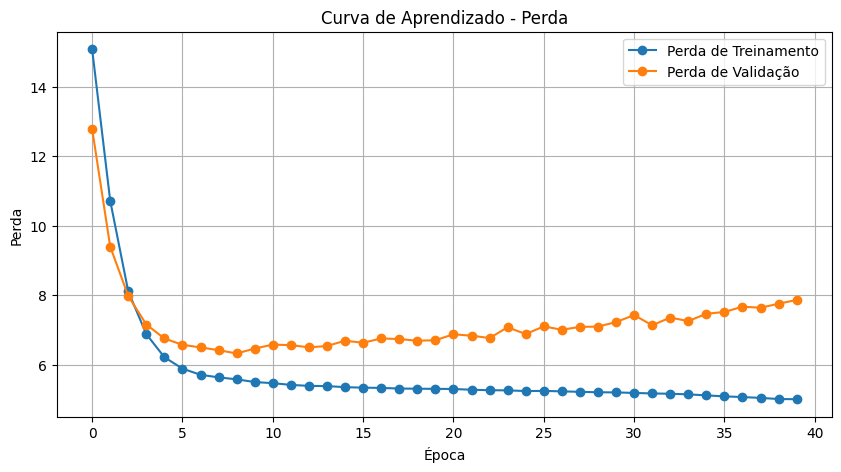

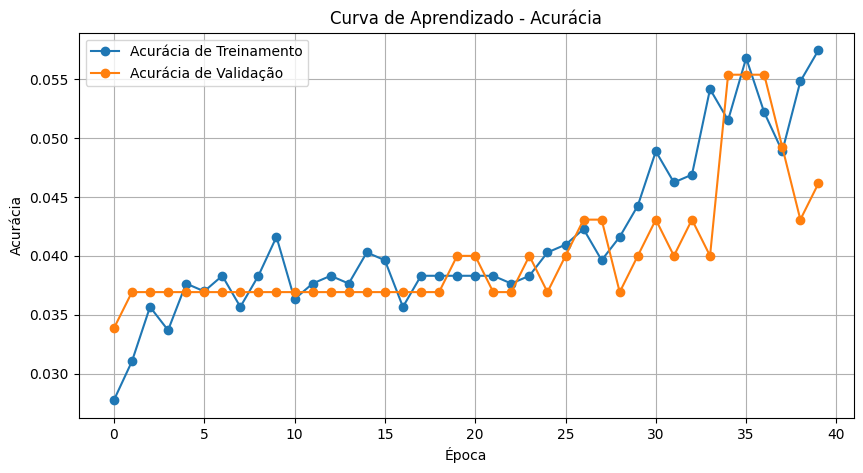

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2


import matplotlib.pyplot as plt

def plot_learning_curve(history):
    """
    Plota as curvas de aprendizado para perda e métricas de validação.
    
    Args:
        history (History): Objeto retornado pelo método `fit` do Keras.
    """
    # Obter os valores do histórico
    loss = history.history['loss']
    val_loss = history.history.get('val_loss', [])
    
    # Plotar a perda
    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='Perda de Treinamento', marker='o')
    if val_loss:
        plt.plot(val_loss, label='Perda de Validação', marker='o')
    plt.title('Curva de Aprendizado - Perda')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Se houver métricas além de perda
    if 'accuracy' in history.history:
        accuracy = history.history['accuracy']
        val_accuracy = history.history.get('val_accuracy', [])
        plt.figure(figsize=(10, 5))
        plt.plot(accuracy, label='Acurácia de Treinamento', marker='o')
        if val_accuracy:
            plt.plot(val_accuracy, label='Acurácia de Validação', marker='o')
        plt.title('Curva de Aprendizado - Acurácia')
        plt.xlabel('Época')
        plt.ylabel('Acurácia')
        plt.legend()
        plt.grid(True)
        plt.show()


# Função para processar os dados
def prepare_data(df, max_len, encoder=None):
    """
    Prepara os dados para o modelo LSTM.
    Args:
        df (pd.DataFrame): Conjunto de dados com histórico de carreira.
        max_len (int): Tamanho máximo das sequências.
        encoder (LabelEncoder): Codificador para ocupações.
    Returns:
        X (np.array): Sequências de entrada.
        y (np.array): Próxima ocupação.
        encoder (LabelEncoder): Codificador ajustado.
    """
    # Codificar as ocupações
    if not encoder:
        encoder = LabelEncoder()
        all_occupations = df[[f"ESCO_uri_{i}" for i in range(17)]].values.flatten()
        encoder.fit([occ for occ in all_occupations if pd.notna(occ)])

    X, y = [], []
    for _, row in df.iterrows():
        # Obter histórico de ocupações
        history = [row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"]) if pd.notna(row[f"ESCO_uri_{i}"])]
        encoded_history = encoder.transform(history)
        if len(encoded_history) > 1:
            X.append(encoded_history[:-1])
            y.append(encoded_history[-1])

    # Preencher as sequências para tamanho fixo
    X = pad_sequences(X, maxlen=max_len, padding='post')
    y = np.array(y)
    return X, y, encoder

# Ajustar o LabelEncoder com todas as ocupações de treino, validação e teste
def fit_label_encoder(*dataframes):
    all_occupations = []
    for df in dataframes:
        all_occupations.extend(
            df[[f"ESCO_uri_{i}" for i in range(17)]].values.flatten()
        )
    all_occupations = [occ for occ in all_occupations if pd.notna(occ)]
    encoder = LabelEncoder()
    encoder.fit(all_occupations)
    return encoder

# Exemplo de uso
encoder = fit_label_encoder(lstm_train, lstm_validation, lstm_test)
# Preparar os dados
max_len = 10  # Define o tamanho máximo da sequência
# Preparar os dados lstm_train, lstm_validation, lstm_test 
X_train, y_train, _ = prepare_data(lstm_train, max_len=10, encoder=encoder)
X_val, y_val, _ = prepare_data(lstm_validation, max_len=10, encoder=encoder)
X_test, y_test, _ = prepare_data(lstm_test, max_len=10, encoder=encoder)

# Construir o modelo LSTM
model = Sequential([
    Embedding(input_dim=len(encoder.classes_), output_dim=64, input_length=max_len),
    LSTM(units=64, kernel_regularizer=l2(0.1), return_sequences=False),
    Dropout(0.4),
    Dense(len(encoder.classes_), activation='softmax')
])


from tensorflow.keras.optimizers import Adam

initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

# from tensorflow.keras.optimizers import SGD
# optimizer = SGD(learning_rate=0.1, momentum=0.9)

# Compilar o modelo
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40, batch_size=64)

plot_learning_curve(history)
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

In [44]:
from sklearn.metrics import accuracy_score

def calculate_metrics_lstm(y_true, y_pred, top_k=[5, 10]):
    """
    Calcula MRR, Recall@5, Recall@10 para predições LSTM.
    Args:
        y_true (np.array): Verdadeiros rótulos.
        y_pred (np.array): Probabilidades previstas pelo modelo.
        top_k (list): Lista de valores k para Recall@k.
    Returns:
        dict: Métricas calculadas.
    """
    mrr = 0
    recalls = {f"R@{k}": 0 for k in top_k}

    for i, true in enumerate(y_true):
        # Obter o ranking das predições
        pred_ranking = np.argsort(y_pred[i])[::-1]
        rank = np.where(pred_ranking == true)[0][0] + 1  # Posição do item correto no ranking

        # Atualizar MRR
        mrr += 1 / rank

        # Atualizar Recall@k
        for k in top_k:
            if rank <= k:
                recalls[f"R@{k}"] += 1

    # Normalizar métricas
    mrr /= len(y_true)
    for k in top_k:
        recalls[f"R@{k}"] = (recalls[f"R@{k}"] / len(y_true)) * 100

    return {"MRR": mrr, **recalls}

# Calcular as métricas
metrics = calculate_metrics_lstm(y_test, y_pred)

# Exibir as métricas
print("Métricas para o modelo LSTM:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"R@5: {metrics['R@5']:.2f}%")
print(f"R@10: {metrics['R@10']:.2f}%")

Métricas para o modelo LSTM:
MRR: 0.1197
R@5: 16.92%
R@10: 24.31%


### GRU4Rec

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Função para preparar os dados
def prepare_gru4rec_data(df, max_len, encoder=None):
    """
    Prepara os dados para GRU4Rec.
    """
    if not encoder:
        encoder = LabelEncoder()
        all_occupations = df[[f"ESCO_uri_{i}" for i in range(17)]].values.flatten()
        encoder.fit([occ for occ in all_occupations if pd.notna(occ)])

    X, y = [], []
    for _, row in df.iterrows():
        history = [row[f"ESCO_uri_{i}"] for i in range(row["number_of_experiences"]) if pd.notna(row[f"ESCO_uri_{i}"])]
        encoded_history = encoder.transform(history)
        if len(encoded_history) > 1:
            X.append(encoded_history[:-1])
            y.append(encoded_history[-1])

    # Padronizar comprimento das sequências
    X = pad_sequences(X, maxlen=max_len, padding='post')
    y = np.array(y)
    return X, y, encoder

# Criar o modelo GRU4Rec
def create_gru4rec_model(vocab_size, max_len, embedding_dim=128, gru_units=128):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        GRU(gru_units, return_sequences=False),
        Dropout(0.3),
        Dense(vocab_size, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Treinamento
def train_gru4rec_model(model, X_train, y_train, X_val, y_val, epochs=40, batch_size=64):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    return history

# Supondo que você tenha um DataFrame `df_train`, `df_val` e `df_test`
max_len = 10  # Defina o comprimento máximo das sequências



# Criar o modelo
vocab_size = len(encoder.classes_)
model = create_gru4rec_model(vocab_size, max_len)

# Treinar o modelo
history = train_gru4rec_model(model, X_train, y_train, X_val, y_val)

# Avaliação
loss, accuracy = model.evaluate(X_test, y_test, batch_size=64)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0070 - loss: 9.5487 - val_accuracy: 0.0369 - val_loss: 10.6513
Epoch 2/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0302 - loss: 13.5030 - val_accuracy: 0.0123 - val_loss: 13.8012
Epoch 3/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0126 - loss: 15.1014 - val_accuracy: 0.0523 - val_loss: 15.0017
Epoch 4/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0221 - loss: 15.2391 - val_accuracy: 0.0585 - val_loss: 16.5084
Epoch 5/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0324 - loss: 15.3749 - val_accuracy: 0.0646 - val_loss: 17.4648
Epoch 6/40
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0327 - loss: 15.4181 - val_accuracy: 0.0554 - val_loss: 16.7341
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0283 - loss: 10.6012     
Loss: 10.3626, Accuracy: 0.0338


In [30]:
def calculate_custom_metrics(model, X_test, y_test, top_k=10):
    predictions = model.predict(X_test)
    top_k_predictions = np.argsort(-predictions, axis=1)[:, :top_k]

    mrr = 0
    recall_5 = 0
    recall_10 = 0

    for i, true_label in enumerate(y_test):
        rank = np.where(top_k_predictions[i] == true_label)[0]
        if len(rank) > 0:
            mrr += 1 / (rank[0] + 1)
            if rank[0] < 5:
                recall_5 += 1
            if rank[0] < 10:
                recall_10 += 1

    mrr /= len(y_test)
    recall_5 = recall_5 / len(y_test) * 100
    recall_10 = recall_10 / len(y_test) * 100

    return {"MRR": mrr, "R@5": recall_5, "R@10": recall_10}

# Avaliar com métricas customizadas
metrics = calculate_custom_metrics(model, X_test, y_test)
print("Custom Metrics:")
print(f"MRR: {metrics['MRR']:.4f}")
print(f"Recall@5: {metrics['R@5']:.2f}%")
print(f"Recall@10: {metrics['R@10']:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Custom Metrics:
MRR: 0.0539
Recall@5: 7.69%
Recall@10: 10.77%


In [31]:
train

,identifier,industry,number_of_experiences,uuid_0,title_0,description_0,start_0,end_0,ESCO_uri_0,ESCO_title_0,...,end_15,ESCO_uri_15,ESCO_title_15,uuid_16,title_16,description_16,start_16,end_16,ESCO_uri_16,ESCO_title_16
0,12717345,CHEF,4,8b05d17d-36de-806f-fc03-9968c90e41c5,Line Cook,- Prepped food for the line and cooked appetiz...,10/2004,04/2005,http://data.europa.eu/esco/occupation/90f75f67...,cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86551046,CHEF,5,f1fc83d8-5d17-d560-93ca-c6873aa402d8,Banquet Cook 2( Lead Cook),- Attended daily BEO meetings\n- Prepped and f...,02/2014,12/2014,http://data.europa.eu/esco/occupation/90f75f67...,cook,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,29772450,CHEF,6,ccfefc21-0391-a0f6-2e56-0149099d633a,Executive Sous Chef / Production Manager,Perform all essential duties as lead chef in t...,01/1988,01/1993,http://data.europa.eu/esco/occupation/a7d6a377...,food production manager,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25924968,CHEF,13,47ea617f-425a-8915-b440-4f7310f75661,Waiter/Pastry,I worked as a Waiter with additional responsib...,07/1999,08/2003,http://data.europa.eu/esco/occupation/d5db9d5c...,waiter/waitress,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23032276,CHEF,11,d3fa44dd-da53-2926-6404-405c17524371,Asst. Kitchen Manager,"Developed daily specials including entrees, so...",07/1994,03/1996,http://data.europa.eu/esco/occupation/01484951...,head chef,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,30709029,BPO,6,1bd58a75-58d2-f68e-6fcb-d984368a407b,Realtor / BPO Specialist / Accredited Buyer's ...,"Negotiate, facilitate, and manage real estate ...",08/1999,05/2003,http://data.europa.eu/esco/occupation/8ec8df02...,real estate agent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716,63158213,BPO,3,1529fe93-8ae1-3304-ffbd-dae877784529,Network Engineer,- Connected switches using trunk links and Eth...,02/2003,08/2009,http://data.europa.eu/esco/occupation/cf2b03cd...,ICT network engineer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1717,38707449,BPO,4,51d8cd00-773c-c0d8-5e43-e92e8a7145fa,Employment Specialists,Maintained and supported a workbench of 100-15...,09/2004,10/2007,http://data.europa.eu/esco/occupation/42a96d07...,employment agent,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1718,69097572,BPO,4,fbeab95b-6417-f5b9-3393-0ac2a94addf4,Multimedia Illustrator,Trained in the use of tear gas and explosives....,07/2007,07/2013,http://data.europa.eu/esco/occupation/69bcbb0a...,graphic designer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
